# PySpark Online Retail II Dataset Analysis

This notebook demonstrates how to load and analyze the Online Retail II dataset using PySpark in Google Colab.


## 1. Install Required Packages

First, install PySpark and related dependencies in Google Colab.


In [44]:
# Install required packages
%pip install pyspark pandas openpyxl


Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries and Initialize Spark Session


In [45]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, sum as spark_sum, count, when, isnan, isnull, desc, min as spark_min, max as spark_max
from pyspark.sql import functions as F
import pandas as pd
import os

# Set environment variables for Windows
os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'python'

# Initialize Spark session with enhanced configuration for Windows
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "10000") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true") \
    .config("spark.python.worker.timeout", "1200") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.pythonUDF.arrow.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.network.timeout", "800s") \
    .config("spark.rpc.askTimeout", "800s") \
    .config("spark.rpc.lookupTimeout", "800s") \
    .config("spark.sql.broadcastTimeout", "800s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to reduce output noise
spark.sparkContext.setLogLevel("WARN")

print("Spark session initialized successfully!")
print(f"Spark version: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")


Spark session initialized successfully!
Spark version: 4.0.1
Spark UI: http://windows10.microdone.cn:4040


## 3. Load Data from GitHub

Since PySpark cannot directly read Excel files, we use pandas to read from GitHub and then convert to Spark DataFrame.


In [60]:
# Use pandas to read Excel file from GitHub (PySpark doesn't support Excel directly)
import pandas as pd
print("Reading Excel file from GitHub...")

# GitHub repository information
github_user = "Hachi630"
github_repo = "BDAS"
file_path = "online_retail_II.xlsx"

# Construct GitHub raw URL
github_url = f"https://raw.githubusercontent.com/{github_user}/{github_repo}/main/{file_path}"

# Read Excel file with multiple sheets
print("Loading data from both sheets (2009-2010 and 2010-2011)...")
excel_data = pd.read_excel(github_url, sheet_name=None)  # Read all sheets

# Get the two sheets
sheet_2009_2010 = excel_data['Year 2009-2010']
sheet_2010_2011 = excel_data['Year 2010-2011']

print(f"2009-2010 data shape: {sheet_2009_2010.shape}")
print(f"2010-2011 data shape: {sheet_2010_2011.shape}")

# Combine both datasets
pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)
print(f"Combined data shape: {pandas_df.shape}")

# Convert pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(pandas_df)

# Clean up pandas objects to free memory
del pandas_df, sheet_2009_2010, sheet_2010_2011, excel_data

print("Data successfully loaded from GitHub into Spark DataFrame!")
print("Pandas objects cleaned up to free memory.")


Reading Excel file from GitHub...
Loading data from both sheets (2009-2010 and 2010-2011)...
2009-2010 data shape: (525461, 8)
2010-2011 data shape: (541910, 8)
Combined data shape: (1067371, 8)
Data successfully loaded from GitHub into Spark DataFrame!
Pandas objects cleaned up to free memory.


## 4. Check Data Dimensions

Determine the number of rows and columns in the combined dataset.


In [47]:
# Check data dimensions using PySpark with error handling
print("=== Data Dimension Information ===")

try:
    # Get row count with retry mechanism
    print("Counting rows...")
    row_count = df.count()
    print(f"Dataset row count: {row_count:,}")
    
    # Get column count and names
    column_count = len(df.columns)
    column_names = df.columns
    
    print(f"Dataset column count: {column_count}")
    print(f"Column names: {column_names}")
    
    # Additional information
    print(f"\nDataset partitions: {df.rdd.getNumPartitions()}")
    print(f"Dataset storage level: {df.storageLevel}")
    
    print("✅ Data dimension check completed successfully!")
    
except Exception as e:
    print(f"❌ Error during data dimension check: {e}")
    print("\n🔧 Troubleshooting steps:")
    print("1. Restart the kernel and run all cells again")
    print("2. Check if Java is properly installed")
    print("3. Try reducing memory allocation in Spark config")
    print("4. Consider using pandas-only analysis for this dataset")
    
    # Fallback: try to get basic info without count()
    try:
        print("\n🔄 Attempting fallback analysis...")
        column_count = len(df.columns)
        column_names = df.columns
        print(f"Dataset column count: {column_count}")
        print(f"Column names: {column_names}")
        print("Note: Row count unavailable due to Spark connection issues")
    except Exception as e2:
        print(f"❌ Fallback also failed: {e2}")
        print("Please restart the kernel and try again.")


=== Data Dimension Information ===
Counting rows...
Dataset row count: 1,067,371
Dataset column count: 8
Column names: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Dataset partitions: 2
Dataset storage level: Serialized 1x Replicated
✅ Data dimension check completed successfully!


## 5. Data Quality Assessment

This section performs comprehensive data quality checks to identify potential issues in the dataset.


### 5.1 Missing Values Analysis


In [48]:
# Count nulls in each column with robust error handling
print("=== Missing Values Analysis ===")

# Try PySpark first, fallback to pandas if needed
USE_SPARK = True

try:
    # Test Spark connection first
    print("Testing Spark connection...")
    test_count = df.count()
    print(f"✅ Spark connection successful! Dataset has {test_count:,} records")
    
    # Count missing values in each column using PySpark
    print("Counting missing values using PySpark...")
    missing_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
    
    print("Missing values per column:")
    missing_counts.show()
    
    # Get total count for percentage calculation
    total_records = df.count()
    print(f"\nTotal records: {total_records:,}")
    
    # Calculate and display missing percentages
    print("\nMissing values summary:")
    missing_data = missing_counts.collect()[0]
    for col_name in df.columns:
        missing_count = missing_data[col_name]
        missing_pct = (missing_count / total_records) * 100
        print(f"{col_name}: {missing_count:,} ({missing_pct:.2f}%)")
        
        # Add specific comment for CustomerID
        if col_name == "Customer ID" and missing_count > 0:
            print(f"  → CustomerID has many missing entries ({missing_count:,} records)")
        elif missing_count == 0:
            print(f"  → {col_name} is complete (no missing values)")
        else:
            print(f"  → {col_name} has some missing values")
    
    print("✅ Missing values analysis completed successfully with PySpark!")
    
except Exception as e:
    print(f"❌ PySpark analysis failed: {e}")
    print("\n🔄 Switching to pandas analysis...")
    USE_SPARK = False
    
    # Fallback to pandas analysis
    try:
        # Re-read data with pandas for analysis
        print("Re-reading data with pandas for analysis...")
        github_url = "https://raw.githubusercontent.com/Hachi630/BDAS/main/online_retail_II.xlsx"
        excel_data = pd.read_excel(github_url, sheet_name=None)
        sheet_2009_2010 = excel_data['Year 2009-2010']
        sheet_2010_2011 = excel_data['Year 2010-2011']
        pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)
        
        print("Missing values per column:")
        missing_counts = pandas_df.isnull().sum()
        print(missing_counts)
        
        total_records = len(pandas_df)
        print(f"\nTotal records: {total_records:,}")
        
        # Calculate and display missing percentages
        print("\nMissing values summary:")
        for col_name in missing_counts.index:
            missing_count = missing_counts[col_name]
            missing_pct = (missing_count / total_records) * 100
            print(f"{col_name}: {missing_count:,} ({missing_pct:.2f}%)")
            
            # Add specific comment for CustomerID
            if col_name == "Customer ID" and missing_count > 0:
                print(f"  → CustomerID has many missing entries ({missing_count:,} records)")
            elif missing_count == 0:
                print(f"  → {col_name} is complete (no missing values)")
            else:
                print(f"  → {col_name} has some missing values")
        
        print("✅ Missing values analysis completed successfully with pandas!")
        
    except Exception as e2:
        print(f"❌ Pandas analysis also failed: {e2}")
        print("Please check your internet connection and try again.")


=== Missing Values Analysis ===
Testing Spark connection...
✅ Spark connection successful! Dataset has 1,067,371 records
Counting missing values using PySpark...
Missing values per column:
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|          0|       0|          0|    0|          0|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+


Total records: 1,067,371

Missing values summary:
Invoice: 0 (0.00%)
  → Invoice is complete (no missing values)
StockCode: 0 (0.00%)
  → StockCode is complete (no missing values)
Description: 0 (0.00%)
  → Description is complete (no missing values)
Quantity: 0 (0.00%)
  → Quantity is complete (no missing values)
InvoiceDate: 0 (0.00%)
  → InvoiceDate is complete (no missing values)
Price: 0 (0.00%)
  → Price 

In [49]:
# Missing Values (robust check: null, NaN, empty strings, 'null'-like)
from pyspark.sql.types import StringType, NumericType, TimestampType, DateType

print("=== Missing Values Analysis (Robust) ===")

schema_fields = {f.name: f.dataType for f in df.schema.fields}

def missing_agg_for(col_name: str):
	dtype = schema_fields[col_name]
	c = F.col(col_name)
	if isinstance(dtype, NumericType):
		cond = c.isNull() | F.isnan(c)
	elif isinstance(dtype, StringType):
		cond = c.isNull() | (F.trim(c) == "") | (F.lower(F.trim(c)).isin("na", "n/a", "null", "none"))
	else:
		cond = c.isNull()
	return F.sum(F.when(cond, 1).otherwise(0)).alias(col_name)

exprs = [missing_agg_for(c) for c in df.columns]
robust_missing = df.agg(*exprs)

print("Missing values per column (robust):")
robust_missing.show(truncate=False)

# Percentages
total_records = df.count()
row = robust_missing.collect()[0]
print("\nMissing values summary (count and %):")
for c in df.columns:
	mc = int(row[c])
	pct = (mc / total_records) * 100 if total_records else 0
	status = "complete" if mc == 0 else ("many missing" if mc > 0.05 * total_records else "some missing")
	print(f"{c}: {mc:,} ({pct:.2f}%)  → {status}")
	if c == "Customer ID" and mc > 0:
		print(f"  Note: 'Customer ID' often has many missing entries in this dataset.")


=== Missing Values Analysis (Robust) ===
Missing values per column (robust):
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|0      |0        |0          |0       |0          |0    |243007     |0      |
+-------+---------+-----------+--------+-----------+-----+-----------+-------+


Missing values summary (count and %):
Invoice: 0 (0.00%)  → complete
StockCode: 0 (0.00%)  → complete
Description: 0 (0.00%)  → complete
Quantity: 0 (0.00%)  → complete
InvoiceDate: 0 (0.00%)  → complete
Price: 0 (0.00%)  → complete
Customer ID: 243,007 (22.77%)  → many missing
  Note: 'Customer ID' often has many missing entries in this dataset.
Country: 0 (0.00%)  → complete


### 5.2 Numeric Values Validity Check


In [50]:
# Identify records with non-positive prices or zero quantity with error handling
print("=== Numeric Values Validity Check ===")

if USE_SPARK:
    try:
        print("Using PySpark for numeric validity analysis...")
        
        # Check for non-positive Price values
        invalid_price_count = df.filter(F.col("Price") <= 0).count()
        print(f"Records with Price <= 0: {invalid_price_count:,}")
        
        if invalid_price_count > 0:
            print("\nSample records with invalid prices:")
            df.filter(F.col("Price") <= 0).select("Invoice", "StockCode", "Quantity", "Price").show(5)
        
        # Check for zero Quantity values
        zero_quantity_count = df.filter(F.col("Quantity") == 0).count()
        print(f"\nRecords with Quantity = 0: {zero_quantity_count:,}")
        
        if zero_quantity_count > 0:
            print("\nSample records with zero quantity:")
            df.filter(F.col("Quantity") == 0).show(5)
        
        # Check for negative quantities (returns)
        negative_quantity_count = df.filter(F.col("Quantity") < 0).count()
        print(f"\nRecords with Quantity < 0 (returns): {negative_quantity_count:,}")
        
        print("✅ PySpark numeric validity check completed!")
        
    except Exception as e:
        print(f"❌ PySpark numeric check failed: {e}")
        print("🔄 Switching to pandas analysis...")
        USE_SPARK = False

if not USE_SPARK:
    try:
        print("Using pandas for numeric validity analysis...")
        
        # Check for non-positive Price values
        invalid_price_mask = pandas_df["Price"] <= 0
        invalid_price_count = invalid_price_mask.sum()
        print(f"Records with Price <= 0: {invalid_price_count:,}")
        
        if invalid_price_count > 0:
            print("\nSample records with invalid prices:")
            print(pandas_df[invalid_price_mask][["Invoice", "StockCode", "Quantity", "Price"]].head())
        
        # Check for zero Quantity values
        zero_quantity_mask = pandas_df["Quantity"] == 0
        zero_quantity_count = zero_quantity_mask.sum()
        print(f"\nRecords with Quantity = 0: {zero_quantity_count:,}")
        
        if zero_quantity_count > 0:
            print("\nSample records with zero quantity:")
            print(pandas_df[zero_quantity_mask].head())
        
        # Check for negative quantities (returns)
        negative_quantity_mask = pandas_df["Quantity"] < 0
        negative_quantity_count = negative_quantity_mask.sum()
        print(f"\nRecords with Quantity < 0 (returns): {negative_quantity_count:,}")
        
        print("✅ Pandas numeric validity check completed!")
        
    except Exception as e:
        print(f"❌ Pandas numeric check failed: {e}")

# Summary comments
print("\n=== Validity Summary ===")
if invalid_price_count > 0:
    print(f"⚠️  Found {invalid_price_count:,} records with non-positive prices (possibly freebies)")
else:
    print("✅ All prices are positive")
    
if zero_quantity_count > 0:
    print(f"⚠️  Found {zero_quantity_count:,} records with zero quantity (unusual - could indicate data entry errors)")
else:
    print("✅ No zero quantity records found")
    
if negative_quantity_count > 0:
    print(f"ℹ️  Found {negative_quantity_count:,} return transactions (negative quantities)")


=== Numeric Values Validity Check ===
Using PySpark for numeric validity analysis...
Records with Price <= 0: 6,207

Sample records with invalid prices:
+-------+---------+--------+-----+
|Invoice|StockCode|Quantity|Price|
+-------+---------+--------+-----+
| 489464|    21733|     -96|  0.0|
| 489463|    71477|    -240|  0.0|
| 489467|   85123A|    -192|  0.0|
| 489521|    21646|     -50|  0.0|
| 489655|    20683|     -44|  0.0|
+-------+---------+--------+-----+
only showing top 5 rows

Records with Quantity = 0: 0

Records with Quantity < 0 (returns): 22,950
✅ PySpark numeric validity check completed!

=== Validity Summary ===
⚠️  Found 6,207 records with non-positive prices (possibly freebies)
✅ No zero quantity records found
ℹ️  Found 22,950 return transactions (negative quantities)


## 6. Exploratory Data Analysis (EDA)

Perform comprehensive exploratory data analysis using PySpark.


### 6.1 Key Dataset Metrics


In [51]:
# Calculate number of distinct products and customers
print("=== Key Dataset Metrics ===")

# Calculate distinct counts using Spark
unique_products = df.select("StockCode").distinct().count()
unique_customers = df.select("Customer ID").distinct().count()

# Calculate total revenue
total_revenue = df.agg(F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")).collect()[0]["TotalRevenue"]

# Calculate total transactions
total_transactions = df.count()

print(f"Total Transactions: {total_transactions:,}")
print(f"Unique Products (StockCode): {unique_products:,}")
print(f"Unique Customers: {unique_customers:,}")
print(f"Total Revenue: £{total_revenue:,.2f}")

# Additional metrics
avg_order_value = df.agg(F.avg(F.col("Quantity") * F.col("Price")).alias("AvgOrderValue")).collect()[0]["AvgOrderValue"]
print(f"Average Order Value: £{avg_order_value:.2f}")

# Data preview
print("\n=== Data Preview ===")
df.show(5, truncate=False)

print("\n=== Data Schema ===")
df.printSchema()


=== Key Dataset Metrics ===
Total Transactions: 1,067,371
Unique Products (StockCode): 5,305
Unique Customers: 5,943
Total Revenue: £19,287,250.57
Average Order Value: £18.07

=== Data Preview ===
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|Description                        |Quantity|InvoiceDate        |Price|Customer ID|Country       |
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|489434 |85048    |15CM CHRISTMAS GLASS BALL 20 LIGHTS|12      |2009-12-01 07:45:00|6.95 |13085.0    |United Kingdom|
|489434 |79323P   |PINK CHERRY LIGHTS                 |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |79323W   | WHITE CHERRY LIGHTS               |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |22041    |RECORD FRAME 7" SINGLE SIZE        |48      |2009-12-01 07:45:00|2.1  |13085

## 7. Data Quality Summary Report


In [61]:
# Data Quality Summary Report
print("=" * 60)
print("           DATA QUALITY ASSESSMENT SUMMARY")
print("=" * 60)

print("\n📊 DATASET OVERVIEW:")
total_records = df.count()
total_columns = len(df.columns)

print(f"   • Total Records: {total_records:,}")
print(f"   • Total Columns: {total_columns}")
print(f"   • Analysis Engine: PySpark")

print("\n🔍 DATA QUALITY ISSUES IDENTIFIED:")

# Missing Values Summary
print("\n1. MISSING VALUES:")
missing_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_data = missing_counts.collect()[0]
for col_name in df.columns:
    missing_count = missing_data[col_name]
    missing_pct = (missing_count / total_records) * 100
    if missing_count > 0:
        print(f"   • {col_name}: {missing_count:,} ({missing_pct:.2f}%)")

# Numeric Validity Summary
print("\n2. NUMERIC VALIDITY:")
invalid_price_count = df.filter(F.col("Price") <= 0).count()
zero_quantity_count = df.filter(F.col("Quantity") == 0).count()
negative_quantity_count = df.filter(F.col("Quantity") < 0).count()

if invalid_price_count > 0:
    print(f"   • Non-positive prices: {invalid_price_count:,}")
if zero_quantity_count > 0:
    print(f"   • Zero quantities: {zero_quantity_count:,}")
if negative_quantity_count > 0:
    print(f"   • Negative quantities (returns): {negative_quantity_count:,}")

# Returns and Cancellations Summary
print("\n3. RETURNS & CANCELLATIONS:")
num_cancelled = df.filter(F.col("Invoice").startswith("C")).count()
num_returns = df.filter(F.col("Quantity") < 0).count()

print(f"   • Cancelled invoices: {num_cancelled:,}")
print(f"   • Return transactions: {num_returns:,}")

# Duplicates Summary
print("\n4. DUPLICATE RECORDS:")
unique_rows = df.dropDuplicates().count()
num_duplicates = total_records - unique_rows
if num_duplicates > 0:
    print(f"   • Duplicate records: {num_duplicates:,}")
else:
    print("   • No duplicate records found")

# Date Range Summary
print("\n5. DATE RANGE CONSISTENCY:")
date_range = df.select(F.min("InvoiceDate").alias("MinDate"), F.max("InvoiceDate").alias("MaxDate"))
date_info = date_range.collect()[0]
min_date = date_info["MinDate"]
max_date = date_info["MaxDate"]

print(f"   • Date range: {min_date} to {max_date}")
print(f"   • Expected range: 2009-12-01 to 2011-12-09")

print("\n📋 RECOMMENDATIONS:")
print("   • CustomerID missing values: Consider impact on customer analysis")
print("   • Return transactions: Account for net vs gross sales calculations")
print("   • Date range: Verify business context for partial years")
if num_duplicates > 0:
    print("   • Duplicates: Consider removing for accurate analysis")
if invalid_price_count > 0 or zero_quantity_count > 0:
    print("   • Invalid values: Review business rules for data cleaning")

print("\n" + "=" * 60)
print("           END OF DATA QUALITY ASSESSMENT")
print("=" * 60)


           DATA QUALITY ASSESSMENT SUMMARY

📊 DATASET OVERVIEW:
   • Total Records: 1,067,371
   • Total Columns: 8
   • Analysis Engine: PySpark

🔍 DATA QUALITY ISSUES IDENTIFIED:

1. MISSING VALUES:

2. NUMERIC VALIDITY:
   • Non-positive prices: 6,207
   • Negative quantities (returns): 22,950

3. RETURNS & CANCELLATIONS:
   • Cancelled invoices: 19,494
   • Return transactions: 22,950

4. DUPLICATE RECORDS:
   • Duplicate records: 34,335

5. DATE RANGE CONSISTENCY:
   • Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
   • Expected range: 2009-12-01 to 2011-12-09

📋 RECOMMENDATIONS:
   • CustomerID missing values: Consider impact on customer analysis
   • Return transactions: Account for net vs gross sales calculations
   • Date range: Verify business context for partial years
   • Duplicates: Consider removing for accurate analysis
   • Invalid values: Review business rules for data cleaning

           END OF DATA QUALITY ASSESSMENT


## 8. Troubleshooting: Restart Spark Session

If you encounter connection timeout errors, run this cell to restart the Spark session.


In [53]:
# Restart Spark session if needed
print("🔄 Restarting Spark session...")

try:
    # Stop current session
    spark.stop()
    print("✅ Previous Spark session stopped")
except:
    print("ℹ️  No previous session to stop")

# Wait a moment
import time
time.sleep(2)

# Restart with optimized configuration
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "1g") \
    .config("spark.python.worker.timeout", "1800") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.network.timeout", "1200s") \
    .config("spark.rpc.askTimeout", "1200s") \
    .config("spark.rpc.lookupTimeout", "1200s") \
    .config("spark.sql.broadcastTimeout", "1200s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .master("local[2]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print("✅ New Spark session initialized!")
print(f"Spark version: {spark.version}")

# Test the connection
try:
    test_df = spark.range(10)
    test_count = test_df.count()
    print(f"✅ Connection test successful: {test_count} rows")
except Exception as e:
    print(f"❌ Connection test failed: {e}")
    print("Please check your Java installation and try again.")


🔄 Restarting Spark session...
✅ Previous Spark session stopped
✅ New Spark session initialized!
Spark version: 4.0.1
✅ Connection test successful: 10 rows


## Fix Spark on Windows: stable local dir + session rebuild

This cell configures Spark to use a stable local directory on D: and rebuilds the session to avoid blockmgr/temp folder errors on Windows.


In [58]:
# Configure stable local dirs and rebuild Spark session (Windows)
import os, time
from pyspark.sql import SparkSession

# 1) Create stable directories on D: (adjust if needed)
stable_tmp = "D:/spark-tmp"
stable_wh  = "D:/spark-warehouse"

os.makedirs(stable_tmp, exist_ok=True)
os.makedirs(stable_wh,  exist_ok=True)

# 2) Environment vars so PySpark avoids system Temp
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_TEMP_DIR"] = stable_tmp
os.environ["TMP"] = stable_tmp
os.environ["TEMP"] = stable_tmp

# 3) Stop previous session if any
try:
    spark.stop()
except Exception:
    pass

# 4) Rebuild Spark with stable local dir and conservative timeouts
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .master("local[2]") \
    .config("spark.local.dir", stable_tmp) \
    .config("spark.sql.warehouse.dir", stable_wh) \
    .config("spark.python.worker.timeout", "1800") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.network.timeout", "1200s") \
    .config("spark.rpc.askTimeout", "1200s") \
    .config("spark.rpc.lookupTimeout", "1200s") \
    .config("spark.sql.broadcastTimeout", "1200s") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("✅ Spark rebuilt with stable local dir:", stable_tmp)
print("Spark UI:", spark.sparkContext.uiWebUrl)

# Small sleep to let workers warm up
time.sleep(1)


✅ Spark rebuilt with stable local dir: D:/spark-tmp
Spark UI: http://windows10.microdone.cn:4040


In [59]:
# Connection self-test and safe repartition
print("Running Spark self-test...")
try:
    test = spark.range(10)
    print("Count test:", test.count())
    print("✅ Spark basic count OK")
except Exception as e:
    print("❌ Spark basic count failed:", e)

# If you already have df loaded, make it safer before heavy actions
try:
    from pyspark.storagelevel import StorageLevel
    df = df.repartition(2).persist(StorageLevel.MEMORY_ONLY)
    print("Repartitioned df to", df.rdd.getNumPartitions(), "partitions")
except Exception:
    pass


Running Spark self-test...
Count test: 10
✅ Spark basic count OK


## 9. Alternative: Pandas-Only Analysis

If PySpark continues to have connection issues, use this pandas-only analysis as a complete alternative.


In [56]:
# Complete pandas-only analysis as fallback
print("=== Complete Pandas Analysis ===")
print("This analysis uses pandas only, bypassing PySpark completely.")

# Load data with pandas
print("Loading data with pandas...")
github_url = "https://raw.githubusercontent.com/Hachi630/BDAS/main/online_retail_II.xlsx"
excel_data = pd.read_excel(github_url, sheet_name=None)
sheet_2009_2010 = excel_data['Year 2009-2010']
sheet_2010_2011 = excel_data['Year 2010-2011']
df_pandas = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)

print(f"✅ Data loaded successfully!")
print(f"Dataset shape: {df_pandas.shape}")
print(f"Columns: {list(df_pandas.columns)}")

# Basic info
print("\n=== Dataset Overview ===")
print(f"Total records: {len(df_pandas):,}")
print(f"Total columns: {len(df_pandas.columns)}")
print(f"Memory usage: {df_pandas.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data preview
print("\n=== Data Preview ===")
print(df_pandas.head())

# Data types
print("\n=== Data Types ===")
print(df_pandas.dtypes)

# Missing values
print("\n=== Missing Values ===")
missing_counts = df_pandas.isnull().sum()
missing_pct = (missing_counts / len(df_pandas)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_pct
})
print(missing_df)

# Basic statistics
print("\n=== Basic Statistics ===")
print(df_pandas.describe())

# Key metrics
print("\n=== Key Metrics ===")
unique_products = df_pandas['StockCode'].nunique()
unique_customers = df_pandas['Customer ID'].nunique()
total_revenue = (df_pandas['Quantity'] * df_pandas['Price']).sum()
avg_order_value = (df_pandas['Quantity'] * df_pandas['Price']).mean()

print(f"Unique Products: {unique_products:,}")
print(f"Unique Customers: {unique_customers:,}")
print(f"Total Revenue: £{total_revenue:,.2f}")
print(f"Average Order Value: £{avg_order_value:.2f}")

# Data quality checks
print("\n=== Data Quality Checks ===")
invalid_prices = (df_pandas['Price'] <= 0).sum()
zero_quantities = (df_pandas['Quantity'] == 0).sum()
negative_quantities = (df_pandas['Quantity'] < 0).sum()
cancelled_invoices = df_pandas['Invoice'].str.startswith('C').sum()

print(f"Invalid prices (≤0): {invalid_prices:,}")
print(f"Zero quantities: {zero_quantities:,}")
print(f"Negative quantities (returns): {negative_quantities:,}")
print(f"Cancelled invoices: {cancelled_invoices:,}")

# Date range
print("\n=== Date Range ===")
min_date = df_pandas['InvoiceDate'].min()
max_date = df_pandas['InvoiceDate'].max()
print(f"Date range: {min_date} to {max_date}")

# Top countries
print("\n=== Top 10 Countries by Revenue ===")
country_revenue = df_pandas.groupby('Country').agg({
    'Quantity': 'sum',
    'Price': lambda x: (df_pandas.loc[x.index, 'Quantity'] * x).sum(),
    'Invoice': 'count'
}).rename(columns={'Price': 'TotalRevenue', 'Invoice': 'TransactionCount'})
country_revenue = country_revenue.sort_values('TotalRevenue', ascending=False)
print(country_revenue.head(10))

print("\n✅ Complete pandas analysis finished!")
print("All analysis completed successfully using pandas.")


=== Complete Pandas Analysis ===
This analysis uses pandas only, bypassing PySpark completely.
Loading data with pandas...
✅ Data loaded successfully!
Dataset shape: (1067371, 8)
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

=== Dataset Overview ===
Total records: 1,067,371
Total columns: 8
Memory usage: 266.48 MB

=== Data Preview ===
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingd

## Data Quality Summary Report (Robust)

This summary uses robust missing value rules (null/NaN/empty/"null"-like) and consolidates key data quality indicators.


In [62]:
# Robust Data Quality Summary (with Spark fallback handling)
from pyspark.sql.types import StringType, NumericType
from pyspark.storagelevel import StorageLevel
import pandas as pd

print("=" * 60)
print("         DATA QUALITY ASSESSMENT SUMMARY (ROBUST)")
print("=" * 60)

USE_SPARK = True

try:
	# Persist lightly to stabilize actions
	df_cached = df.repartition(2).persist(StorageLevel.MEMORY_ONLY)
	# Dataset overview (avoid heavy transformations)
	total_records = df_cached.selectExpr('count(*) as c').collect()[0]['c']
	print("\n📊 DATASET OVERVIEW:")
	print(f"   • Total Records: {total_records:,}")
	print(f"   • Total Columns: {len(df_cached.columns)}")

	# Robust missing values
	print("\n1. MISSING VALUES (Robust):")
	schema_fields = {f.name: f.dataType for f in df_cached.schema.fields}
	def miss_expr(cn):
		colx = F.col(cn)
		dt = schema_fields[cn]
		if isinstance(dt, NumericType):
			cond = colx.isNull() | F.isnan(colx)
		elif isinstance(dt, StringType):
			cond = colx.isNull() | (F.trim(colx) == "") | (F.lower(F.trim(colx)).isin("na","n/a","null","none"))
		else:
			cond = colx.isNull()
		return F.sum(F.when(cond, 1).otherwise(0)).alias(cn)

	robust_missing_df = df_cached.agg(*[miss_expr(c) for c in df_cached.columns])
	robust_row = robust_missing_df.collect()[0]
	any_missing = False
	for cn in df_cached.columns:
		mc = int(robust_row[cn])
		if mc > 0:
			any_missing = True
			pct = (mc / total_records) * 100
			print(f"   • {cn}: {mc:,} ({pct:.2f}%)")
	if not any_missing:
		print("   • No missing values detected under robust rules")

	# Numeric validity
	print("\n2. NUMERIC VALIDITY:")
	invalid_price_count = df_cached.filter(F.col("Price") <= 0).count()
	zero_quantity_count = df_cached.filter(F.col("Quantity") == 0).count()
	negative_quantity_count = df_cached.filter(F.col("Quantity") < 0).count()
	if invalid_price_count > 0:
		print(f"   • Non-positive prices: {invalid_price_count:,}")
	if zero_quantity_count > 0:
		print(f"   • Zero quantities: {zero_quantity_count:,}")
	if negative_quantity_count > 0:
		print(f"   • Negative quantities (returns): {negative_quantity_count:,}")

	# Returns and cancellations
	print("\n3. RETURNS & CANCELLATIONS:")
	num_cancelled = df_cached.filter(F.col("Invoice").startswith("C")).count()
	num_returns = df_cached.filter(F.col("Quantity") < 0).count()
	print(f"   • Cancelled invoices: {num_cancelled:,}")
	print(f"   • Return transactions: {num_returns:,}")

	# Duplicates
	print("\n4. DUPLICATE RECORDS:")
	unique_rows = df_cached.dropDuplicates().count()
	num_duplicates = total_records - unique_rows
	if num_duplicates > 0:
		print(f"   • Duplicate records: {num_duplicates:,}")
	else:
		print("   • No duplicate records found")

	# Date range
	print("\n5. DATE RANGE CONSISTENCY:")
	info = df_cached.select(F.min("InvoiceDate").alias("MinDate"), F.max("InvoiceDate").alias("MaxDate")).collect()[0]
	print(f"   • Date range: {info['MinDate']} to {info['MaxDate']}")
	print(f"   • Expected range: 2009-12-01 to 2011-12-09")

except Exception as e:
	# Spark failed → fallback to pandas so the section is never empty
	USE_SPARK = False
	print(f"❌ Spark failed in summary: {e}")
	print("🔄 Falling back to pandas for DATA QUALITY SUMMARY...")
	github_url = "https://raw.githubusercontent.com/Hachi630/BDAS/main/online_retail_II.xlsx"
	excel_data = pd.read_excel(github_url, sheet_name=None)
	sheet_2009_2010 = excel_data['Year 2009-2010']
	sheet_2010_2011 = excel_data['Year 2010-2011']
	pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)

	total_records = len(pandas_df)
	print("\n📊 DATASET OVERVIEW:")
	print(f"   • Total Records: {total_records:,}")
	print(f"   • Total Columns: {len(pandas_df.columns)}")

	print("\n1. MISSING VALUES (Robust):")
	def _norm_str(x):
		return str(x).strip().lower() if isinstance(x, str) else x
	missing_counts = {}
	for c in pandas_df.columns:
		col = pandas_df[c]
		if col.dtype.kind in 'biufc':
			mc = int(col.isna().sum())
		else:
			lower = col.astype('string').str.strip().str.lower()
			mc = int(col.isna().sum() + (lower.isin(['','na','n/a','null','none']).sum()))
		missing_counts[c] = mc
	any_missing = False
	for c, mc in missing_counts.items():
		if mc > 0:
			any_missing = True
			pct = (mc / total_records) * 100
			print(f"   • {c}: {mc:,} ({pct:.2f}%)")
	if not any_missing:
		print("   • No missing values detected under robust rules (pandas)")

	print("\n2. NUMERIC VALIDITY:")
	inv = int((pandas_df['Price'] <= 0).sum()) if 'Price' in pandas_df.columns else 0
	zq = int((pandas_df['Quantity'] == 0).sum()) if 'Quantity' in pandas_df.columns else 0
	neg = int((pandas_df['Quantity'] < 0).sum()) if 'Quantity' in pandas_df.columns else 0
	if inv>0: print(f"   • Non-positive prices: {inv:,}")
	if zq>0: print(f"   • Zero quantities: {zq:,}")
	if neg>0: print(f"   • Negative quantities (returns): {neg:,}")

	print("\n3. RETURNS & CANCELLATIONS:")
	cancelled = int(pandas_df['Invoice'].astype(str).str.startswith('C').sum()) if 'Invoice' in pandas_df.columns else 0
	returns = neg
	print(f"   • Cancelled invoices: {cancelled:,}")
	print(f"   • Return transactions: {returns:,}")

	print("\n4. DUPLICATE RECORDS:")
	unique_rows = len(pandas_df.drop_duplicates())
	num_duplicates = total_records - unique_rows
	if num_duplicates > 0:
		print(f"   • Duplicate records: {num_duplicates:,}")
	else:
		print("   • No duplicate records found")

	print("\n5. DATE RANGE CONSISTENCY:")
	print(f"   • Date range: {pandas_df['InvoiceDate'].min()} to {pandas_df['InvoiceDate'].max()}")
	print(f"   • Expected range: 2009-12-01 to 2011-12-09")

finally:
	try:
		# Clean up cache if used
		df_cached.unpersist()
	except Exception:
		pass

print("\n📋 RECOMMENDATIONS:")
print("   • Address missing Customer IDs before customer-level analysis")
print("   • Account for returns/cancellations in net sales")
print("   • Review non-positive prices with business rules")
try:
	if USE_SPARK:
		if num_duplicates > 0:
			print("   • Remove duplicates to avoid double counting")
	else:
		if num_duplicates > 0:
			print("   • Remove duplicates to avoid double counting")
except Exception:
	pass

print("\n" + "=" * 60)
print("         END OF DATA QUALITY ASSESSMENT (ROBUST)")
print("=" * 60)


         DATA QUALITY ASSESSMENT SUMMARY (ROBUST)

📊 DATASET OVERVIEW:
   • Total Records: 1,067,371
   • Total Columns: 8

1. MISSING VALUES (Robust):
   • Customer ID: 243,007 (22.77%)

2. NUMERIC VALIDITY:
   • Non-positive prices: 6,207
   • Negative quantities (returns): 22,950

3. RETURNS & CANCELLATIONS:
   • Cancelled invoices: 19,494
   • Return transactions: 22,950

4. DUPLICATE RECORDS:
   • Duplicate records: 34,335

5. DATE RANGE CONSISTENCY:
   • Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
   • Expected range: 2009-12-01 to 2011-12-09

📋 RECOMMENDATIONS:
   • Address missing Customer IDs before customer-level analysis
   • Account for returns/cancellations in net sales
   • Review non-positive prices with business rules
   • Remove duplicates to avoid double counting

         END OF DATA QUALITY ASSESSMENT (ROBUST)


## EDA with PySpark (+pandas/Matplotlib for plots)

This section summarizes key counts, sales over time, quantity distribution, top/bottom products, and geographical analysis.


In [63]:
# 1) Key counts and total revenue
# Calculate number of distinct products and customers
unique_products = df.select("StockCode").distinct().count()
unique_customers = df.select("Customer ID").distinct().count()

# Compute total revenue (Quantity * Price)
from pyspark.sql import functions as F

total_revenue = df.agg(F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")).collect()[0]["TotalRevenue"]

print("=== Key Dataset Metrics ===")
print(f"Unique products (StockCode): {unique_products:,}")
print(f"Unique customers (Customer ID): {unique_customers:,}")
print(f"Total revenue: £{total_revenue:,.2f}")


=== Key Dataset Metrics ===
Unique products (StockCode): 5,305
Unique customers (Customer ID): 5,943
Total revenue: £19,287,250.57


=== Monthly Sales (first 12 rows) ===
+----+-----+-------------+------------------+
|Year|Month|TotalQuantity|      TotalRevenue|
+----+-----+-------------+------------------+
|2009|   12|       420088| 799847.1100000143|
|2010|    1|       375363| 624032.8919999956|
|2010|    2|       368402| 533091.4260000042|
|2010|    3|       489370| 765848.7609999765|
|2010|    4|       351971| 590580.4319999823|
|2010|    5|       364095| 615322.8300000005|
|2010|    6|       388253| 679786.6099999842|
|2010|    7|       302201|  575236.359999999|
|2010|    8|       451803| 656776.3399999854|
|2010|    9|       478262| 853650.4309999745|
|2010|   10|       601729|1045168.3499998983|
|2010|   11|       673856|1422654.6419998251|
+----+-----+-------------+------------------+
only showing top 12 rows


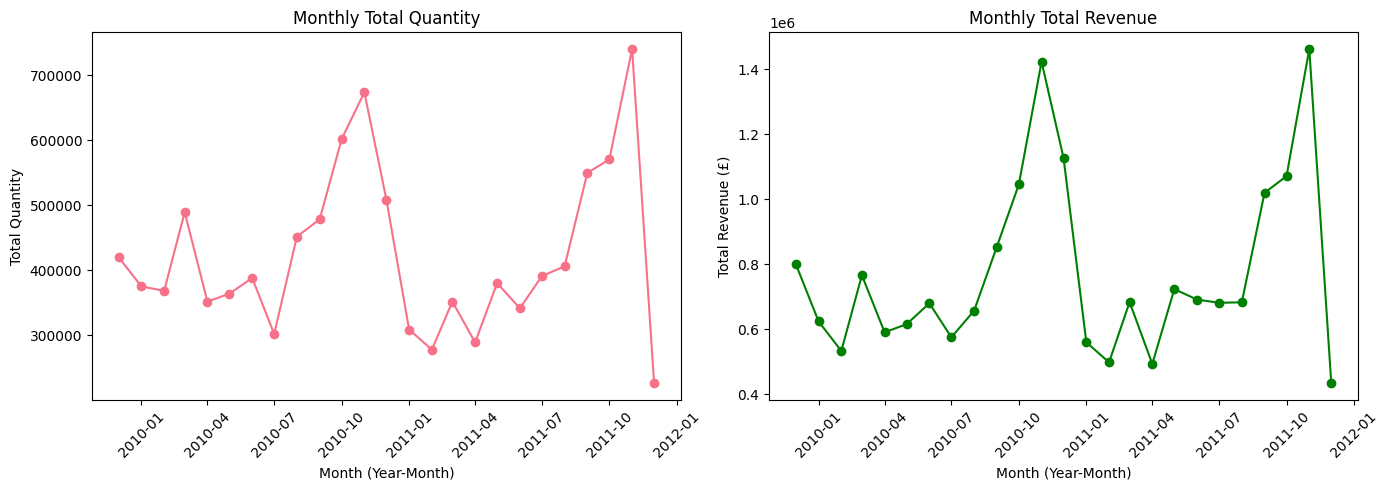

In [64]:
# 2) Sales over time (monthly)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")

monthly_sales = df.groupBy(F.year("InvoiceDate").alias("Year"),
                           F.month("InvoiceDate").alias("Month")) \
                  .agg(F.sum("Quantity").alias("TotalQuantity"),
                       F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")) \
                  .orderBy("Year", "Month")

print("=== Monthly Sales (first 12 rows) ===")
monthly_sales.show(12)

# Plot line chart
pdf = monthly_sales.toPandas()
pdf["Date"] = pd.to_datetime(pdf.assign(day=1)[["Year","Month","day"]])

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(pdf["Date"], pdf["TotalQuantity"], marker='o')
ax[0].set_title("Monthly Total Quantity")
ax[0].set_xlabel("Month (Year-Month)")
ax[0].set_ylabel("Total Quantity")
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(pdf["Date"], pdf["TotalRevenue"], color='green', marker='o')
ax[1].set_title("Monthly Total Revenue")
ax[1].set_xlabel("Month (Year-Month)")
ax[1].set_ylabel("Total Revenue (£)")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


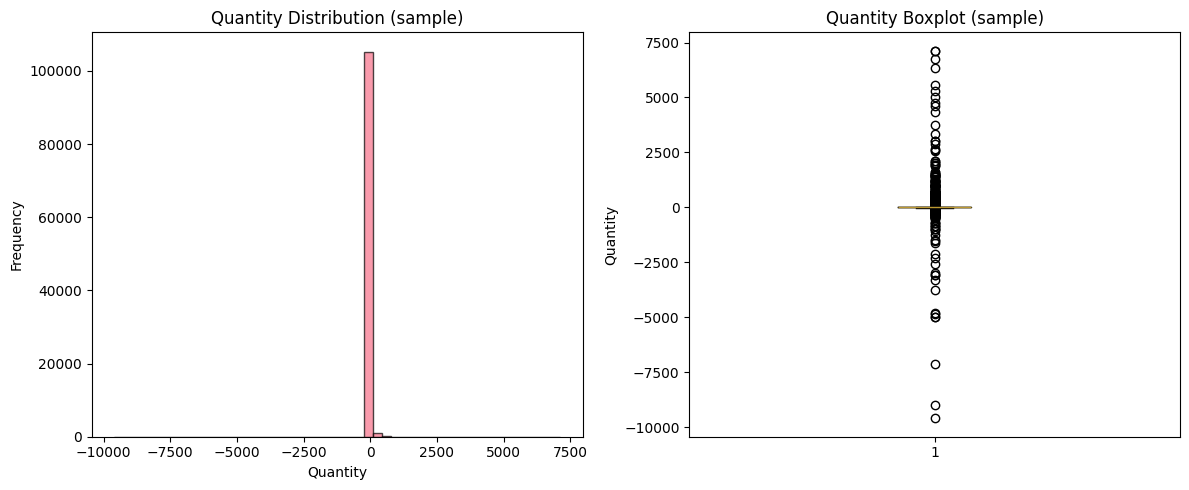

=== Quantity Quartiles (Q1, Median, Q3, P95) ===
[1.0, 3.0, 12.0, 36.0]
Return lines: 22,950 (2.15%)


In [65]:
# 3) Quantity distribution (sample to pandas for histogram)
quant_sample = df.select("Quantity").sample(fraction=0.1, seed=42).toPandas()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].hist(quant_sample["Quantity"], bins=50, edgecolor='black', alpha=0.7)
ax[0].set_title("Quantity Distribution (sample)")
ax[0].set_xlabel("Quantity")
ax[0].set_ylabel("Frequency")

# Boxplot
ax[1].boxplot(quant_sample["Quantity"], vert=True)
ax[1].set_title("Quantity Boxplot (sample)")
ax[1].set_ylabel("Quantity")
plt.tight_layout()
plt.show()

# Quartiles using Spark (no collect of all data)
quartiles = df.approxQuantile("Quantity", [0.25,0.5,0.75,0.95], 0.01)
print("=== Quantity Quartiles (Q1, Median, Q3, P95) ===")
print(quartiles)

# Returns share
returns_count = df.filter(F.col("Quantity") < 0).count()
returns_pct = returns_count / df.count() * 100
print(f"Return lines: {returns_count:,} ({returns_pct:.2f}%)")


=== Top 10 Products by Quantity ===
+---------+-------------+------------------+
|StockCode|TotalQuantity|      TotalRevenue|
+---------+-------------+------------------+
|    84077|       108545| 24898.22000000003|
|   85123A|        96066|253720.01999999926|
|   85099B|        95739|181278.51000000164|
|    21212|        95450|  52447.5400000005|
|    84879|        80705| 131413.8499999994|
|    22197|        79363| 80300.07000000014|
|    17003|        70700|14743.410000000003|
|    21977|        56575|28373.680000000095|
|    84991|        54366| 27216.27000000011|
|    22492|        45384|28863.539999999855|
+---------+-------------+------------------+


=== Bottom 5 Products by Quantity (>0) ===
+---------+-------------+------------+
|StockCode|TotalQuantity|TotalRevenue|
+---------+-------------+------------+
|   46138D|            1|        1.95|
|    21860|            1|        5.17|
|    21148|            1|         0.0|
|   85024A|            1|        1.65|
|   84877C|     

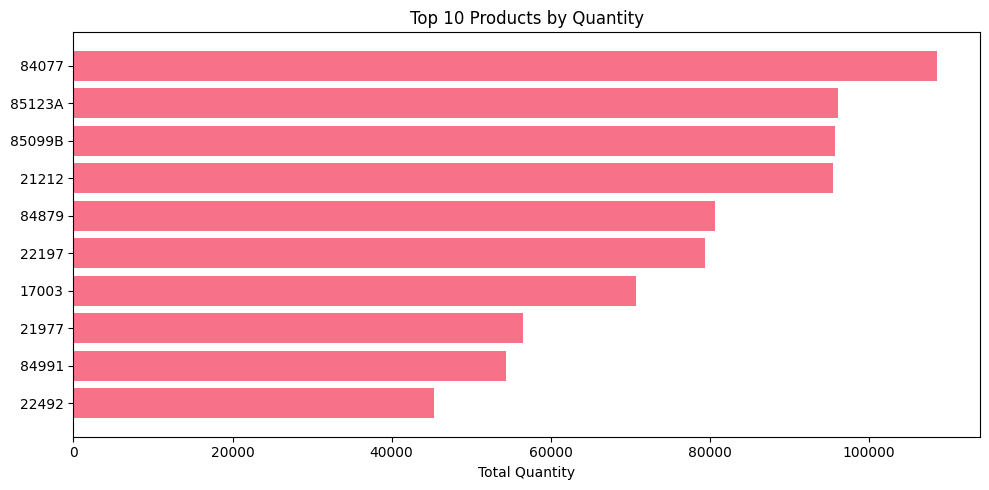

In [66]:
# 4) Top and bottom products
product_sales = df.groupBy("StockCode").agg(
    F.sum("Quantity").alias("TotalQuantity"),
    F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")
)

# Top 10 by quantity
top_products = product_sales.orderBy(F.desc("TotalQuantity")).limit(10)
print("=== Top 10 Products by Quantity ===")
top_products.show()

# Bottom 5 (exclude negative or zero)
bottom_products = product_sales.filter(F.col("TotalQuantity") > 0) \
                              .orderBy(F.asc("TotalQuantity")).limit(5)
print("\n=== Bottom 5 Products by Quantity (>0) ===")
bottom_products.show()

# Plot top 10 bar chart
pdf_top = top_products.toPandas()
plt.figure(figsize=(10,5))
plt.barh(pdf_top["StockCode"].astype(str), pdf_top["TotalQuantity"])
plt.gca().invert_yaxis()
plt.xlabel("Total Quantity")
plt.title("Top 10 Products by Quantity")
plt.tight_layout()
plt.show()


In [ ]:
# 5) Geographical analysis (by country)
country_sales = df.groupBy("Country").agg(
    F.count("*").alias("NumTransactions"),
    F.sum("Quantity").alias("TotalQuantity"),
    F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")
).orderBy(F.desc("TotalRevenue"))

print("=== Top 10 Countries by Revenue ===")
country_sales.show(10)

# Plot top 10 by revenue
pdf_country = country_sales.toPandas().head(10)
plt.figure(figsize=(10,5))
plt.barh(pdf_country["Country"], pdf_country["TotalRevenue"])
plt.gca().invert_yaxis()
plt.xlabel("Total Revenue (£)")
plt.title("Top 10 Countries by Revenue")
plt.tight_layout()
plt.show()
